# Imports

In [1]:
from utils_models import *
# import glob
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
# import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

# Normalization Values

In [ ]:
# r_paths = glob.glob(r'../data/warren/patches_09_27_2024/*_aerialr.tif')
# r_mean, r_std = get_norm_data(r_paths)

# g_paths = glob.glob(r'../data/warren/patches_09_27_2024/*_aerialg.tif')
# g_mean, g_std = get_norm_data(g_paths)

# b_paths = glob.glob(r'../data/warren/patches_09_27_2024/*_aerialb.tif')
# b_mean, b_std = get_norm_data(b_paths)

# rgb_means = [r_mean, g_mean, b_mean]
# rgb_stds = [r_std, g_std, b_std]

# print(rgb_means)
# print(rgb_stds)

In [ ]:
# dem_paths = glob.glob(r'../data/warren/patches_09_27_2024/*_dem*.tif')
# dem_means, dem_stds = get_norm_data(dem_paths)

# print(dem_means)
# print(dem_stds)

# Example Batch

RGB
type: <class 'torch.Tensor'>  |  dtype: torch.float32  |  shape: torch.Size([2, 3, 256, 256])  |  min: 3.1325292587280273  |  max: 254.0
DEM
type: <class 'torch.Tensor'>  |  dtype: torch.float32  |  shape: torch.Size([2, 1, 256, 256])  |  min: 597.962646484375  |  max: 622.4135131835938
Label
type: <class 'torch.Tensor'>  |  dtype: torch.float32  |  shape: torch.Size([2, 1, 7])




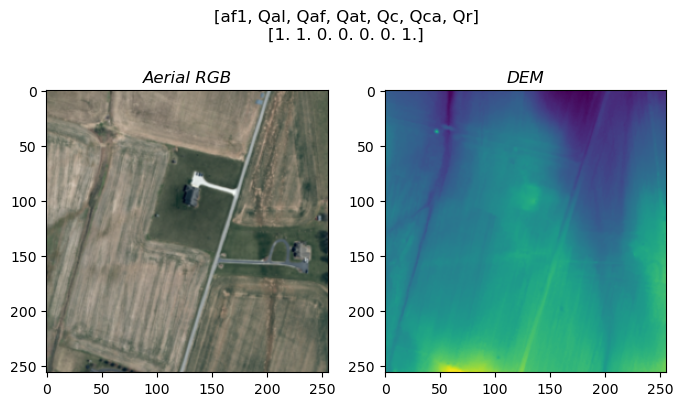

In [22]:
# get list of patch ids in dataset...
patch_ids_path = r'../data/warren/patches_09_27_2024/patch_ids.csv'    # path to patch id csv
patch_ids = pd.read_csv(patch_ids_path, header=None)                              # read csv as df
patch_ids = patch_ids.iloc[:,0].to_list()                                         # df to series to list

# call custom dataset (no transforms for plotting here)...
example_dataset = MultiModalDataset(patch_ids,
                                    r'../data/warren/patches_09_27_2024',
                                    transform_rgb=None,
                                    transform_dem=None,
                                    horiz_flip=True, 
                                    vert_flip=True, 
                                    rand_rot=True)

# create dataloader of batch size 1
example_loader = DataLoader(example_dataset, batch_size=2)

# get first batch from dataloader
batch = next(iter(example_loader))

# print type, dtype, shape, min value, and max values...
print(f"RGB\ntype: {type(batch['rgb'])}  |  dtype: {batch['rgb'].dtype}  |  shape: {batch['rgb'].shape}  |  min: {batch['rgb'].min()}  |  max: {batch['rgb'].max()}")
print(f"DEM\ntype: {type(batch['dem'])}  |  dtype: {batch['dem'].dtype}  |  shape: {batch['dem'].shape}  |  min: {batch['dem'].min()}  |  max: {batch['dem'].max()}")
print(f"Label\ntype: {type(batch['label'])}  |  dtype: {batch['label'].dtype}  |  shape: {batch['label'].shape}")
print('\n')

# plot example batch...
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

# prepare images for plotting with imshow (copy, to numpy, minmaxscaler)
rgb_example = prep_image_for_plot(batch['rgb'][0])
dem_example = prep_image_for_plot(batch['dem'][0])
label_example = batch['label'][0].numpy()

# plot images with label as title
ax[0].imshow(rgb_example, vmin=0, vmax=255)
ax[0].set_title('Aerial RGB', style='italic')
ax[1].imshow(dem_example, cmap='viridis')
ax[1].set_title('DEM', style='italic')
plt.suptitle(f"[af1, Qal, Qaf, Qat, Qc, Qca, Qr]\n{label_example.squeeze()}", y=1.05)
plt.show()

# DataLoaders

In [23]:
# get list of patch ids in dataset
patch_ids_path = r'../data/warren/patches_09_27_2024/patch_ids.csv'    # path to patch id csv
patch_ids = pd.read_csv(patch_ids_path, header=None)                              # read csv as dataframe
patch_ids = patch_ids.iloc[:,0].to_list()                                         # df to series to list


# training, validation, and testing sets
train_size = int(len(patch_ids) * 0.7)
val_size = int(len(patch_ids) * 0.15)
test_size = len(patch_ids) - train_size - val_size


# randomly split list of patch ids into train, validation, and test sets
train_patches, val_patches, test_patches = random_split(patch_ids, [train_size, val_size, test_size])


# define transforms...
# normalization values calculated from entire dataset
rgb_means = [82.34144592285156, 82.34144592285156, 60.32989501953125]
rgb_stds = [35.15250749710626, 35.15250749710626, 11.364835230788147]
dem_means = [693.0260620117188]
dem_stds = [58.23499697372154]

rgb_transforms = transforms.Compose([transforms.Normalize(rgb_means, rgb_stds)])
dem_transforms = transforms.Compose([transforms.Normalize([dem_means], [dem_stds])])


# custom datasets...
train_dataset = MultiModalDataset(train_patches,
                                  r'../data/warren/patches_09_27_2024',
                                  transform_rgb=rgb_transforms,
                                  transform_dem=dem_transforms,
                                  horiz_flip=True, 
                                  vert_flip=True, 
                                  rand_rot=True)

val_dataset = MultiModalDataset(val_patches,
                                r'../data/warren/patches_09_27_2024',
                                transform_rgb=rgb_transforms,
                                transform_dem=dem_transforms,
                                horiz_flip=True, 
                                vert_flip=True, 
                                rand_rot=True)

test_dataset = MultiModalDataset(train_patches,
                                 r'../data/warren/patches_09_27_2024',
                                 transform_rgb=rgb_transforms,
                                 transform_dem=dem_transforms,
                                 horiz_flip=True, 
                                 vert_flip=True, 
                                 rand_rot=True)

# dataloaders...
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

# Train & Validation

In [24]:
if torch.cuda.is_available():
    print('GPU is available. Using GPU.')
else:
    print('GPU not available. Using CPU.')

GPU not available. Using CPU.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FullModel(num_classes=7).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
num_epochs = 25
output_dir = r'../data/warren/model_output'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc = train_model(model, 
                                                                               train_loader, 
                                                                               val_loader, 
                                                                               criterion, 
                                                                               optimizer, 
                                                                               device, 
                                                                               num_epochs, 
                                                                               output_dir)

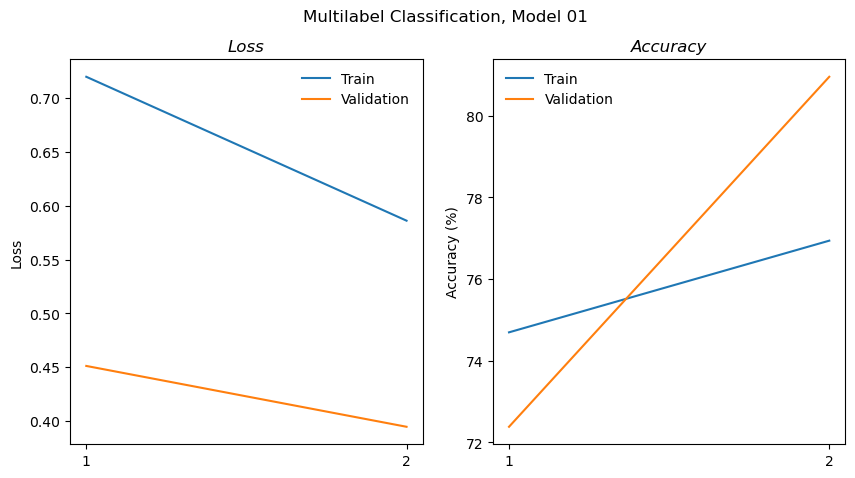

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

epochs = range(1, len(epoch_train_loss)+1)

ax[0].plot(epochs, epoch_train_loss, label='Train')
ax[0].plot(epochs, epoch_val_loss, label='Validation')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss', style='italic')

ax[1].plot(epochs, epoch_train_acc, label='Train')
ax[1].plot(epochs, epoch_val_acc, label='Validation')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Accuracy', style='italic')

for axes in ax:
    axes.legend(frameon=False)
    axes.set_xticks(epochs)

plt.suptitle('Multilabel Classification, Model 01')
plt.show()


# Test

## *Per label Metrics*

In [ ]:
##### Precision, Recall, F1, AUC-ROC, Average Precision

In [ ]:
##### Visualizations - Precision-Recall Curve & ROC Curve

## *Overall Metrics*

In [ ]:
##### Averaged over all labels - Precision, Recall, F1, AUC-ROC, & mean Average Precision (mAP), Hamming loss, Subset Accuracy

## *Tuned Results*

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load(r'../data/warren/model_output/best_model.pth', map_location='cpu'))

model.eval()

/var/folders/gf/gcyl3xv12kq1njc8q6hm7v2h0000gn/T/ipykernel_88015/592612379.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'../data/war

FullModel(
  (rgb_extractor): SensorFeatureExtractor(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dem_extractor): SensorFeatureExtractor(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, 

In [18]:
val_patches = pd.read_csv(r'../data/warren/model_output/validation_patches.csv')
val_patches = val_patches['patch_id'].to_list()

test_patches = pd.read_csv(r'../data/warren/model_output/test_patches.csv')
test_patches = test_patches['patch_id'].to_list()

print(len(val_patches))
print(len(test_patches))

3534
3536


In [32]:
# define transforms...
# normalization values calculated from entire dataset
rgb_means = [82.34144592285156, 82.34144592285156, 60.32989501953125]
rgb_stds = [35.15250749710626, 35.15250749710626, 11.364835230788147]
dem_means = [693.0260620117188]
dem_stds = [58.23499697372154]

rgb_transforms = transforms.Compose([transforms.Normalize(rgb_means, rgb_stds)])
dem_transforms = transforms.Compose([transforms.Normalize([dem_means], [dem_stds])])


# datasets...
val_dataset = MultiModalDataset(val_patches,
                                r'../data/warren/patches_09_27_2024',
                                transform_rgb=rgb_transforms,
                                transform_dem=dem_transforms,
                                horiz_flip=False, 
                                vert_flip=False, 
                                rand_rot=False)

test_dataset = MultiModalDataset(test_patches,
                                 r'../data/warren/patches_09_27_2024',
                                 transform_rgb=rgb_transforms,
                                 transform_dem=dem_transforms,
                                 horiz_flip=False, 
                                 vert_flip=False, 
                                 rand_rot=False)

# dataloaders...
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

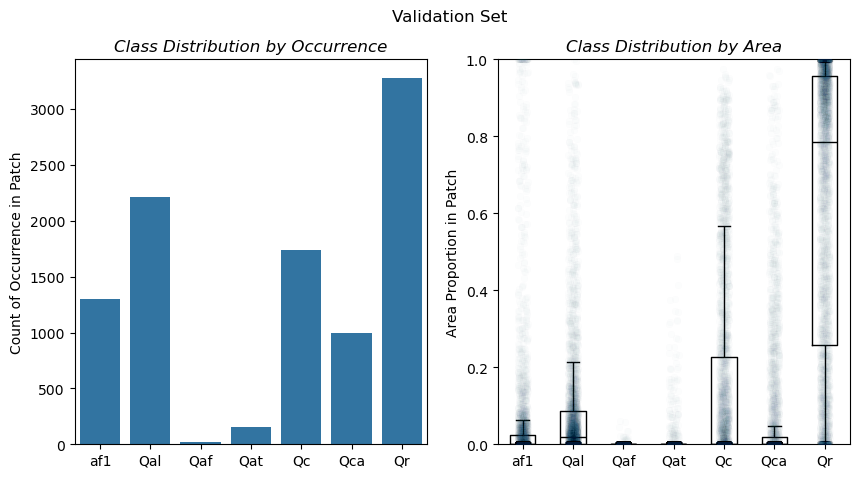

In [33]:
count_path = r'../data/warren/patches_256_50_labels.csv'
df_count = pd.read_csv(count_path)
df_count = df_count.loc[df_count['patch_id'].isin(val_patches)]
counts = df_count.iloc[:, 1:].sum(axis=0)
counts = pd.DataFrame(counts)
counts.head()

area_path = r'../data/warren/patches_256_50_areas.csv'
df_area = pd.read_csv(area_path)
df_area = df_area.loc[df_area['patch_id'].isin(val_patches)]
df_area_long = df_area.iloc[:, 1:].melt(var_name='Geologic Map Unit', value_name='Proportion')


fig, ax = plt.subplots(ncols=2, figsize=(10,5))

# counts...
sns.barplot(ax=ax[0], data=counts, x=counts.index, y=0)
ax[0].set_xlabel('')
ax[0].set_ylabel('Count of Occurrence in Patch')
ax[0].set_title('Class Distribution by Occurrence', style='italic')


# areas...
sns.boxplot(ax=ax[1], data=df_area_long, x='Geologic Map Unit', y='Proportion', showfliers=False, fill=False, color='k', width=0.5, linewidth=1)

sns.stripplot(ax=ax[1], data=df_area_long, x='Geologic Map Unit', y='Proportion', jitter=True, edgecolor='k', linewidth=0.2, alpha=0.01, facecolor='#3A6D8C')

ax[1].set_xlabel('')
ax[1].set_ylabel('Area Proportion in Patch')
ax[1].set_title('Class Distribution by Area', style='italic')


plt.ylim(0,1)
plt.suptitle('Validation Set')
plt.show()

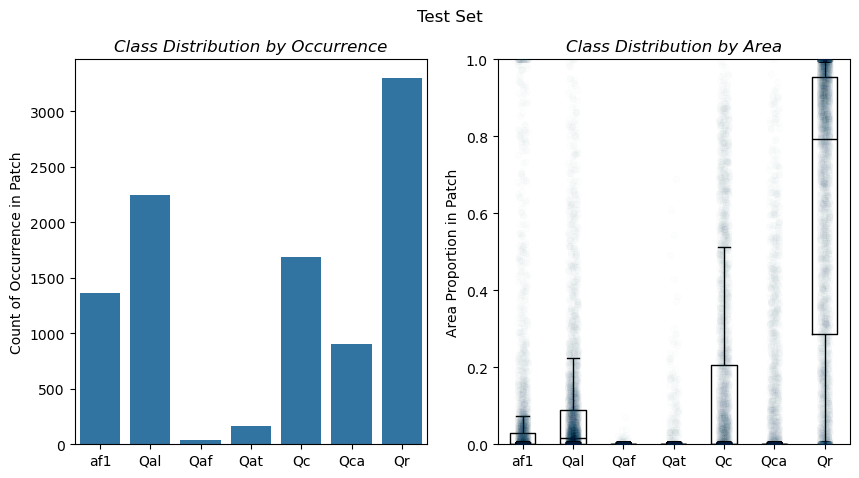

In [34]:
count_path = r'../data/warren/patches_256_50_labels.csv'
df_count = pd.read_csv(count_path)
df_count = df_count.loc[df_count['patch_id'].isin(test_patches)]
counts = df_count.iloc[:, 1:].sum(axis=0)
counts = pd.DataFrame(counts)
counts.head()

area_path = r'../data/warren/patches_256_50_areas.csv'
df_area = pd.read_csv(area_path)
df_area = df_area.loc[df_area['patch_id'].isin(test_patches)]
df_area_long = df_area.iloc[:, 1:].melt(var_name='Geologic Map Unit', value_name='Proportion')


fig, ax = plt.subplots(ncols=2, figsize=(10,5))

# counts...
sns.barplot(ax=ax[0], data=counts, x=counts.index, y=0)
ax[0].set_xlabel('')
ax[0].set_ylabel('Count of Occurrence in Patch')
ax[0].set_title('Class Distribution by Occurrence', style='italic')


# areas...
sns.boxplot(ax=ax[1], data=df_area_long, x='Geologic Map Unit', y='Proportion', showfliers=False, fill=False, color='k', width=0.5, linewidth=1)

sns.stripplot(ax=ax[1], data=df_area_long, x='Geologic Map Unit', y='Proportion', jitter=True, edgecolor='k', linewidth=0.2, alpha=0.01, facecolor='#3A6D8C')

ax[1].set_xlabel('')
ax[1].set_ylabel('Area Proportion in Patch')
ax[1].set_title('Class Distribution by Area', style='italic')


plt.ylim(0,1)
plt.suptitle('Test Set')
plt.show()

In [35]:
test_predictions, test_targets = test_model(model, test_loader, device='cpu', output_dir=None)

In [38]:
test_predictions.shape

(3520, 7)

In [44]:
df = pd.DataFrame(columns=['MapUnit', 'Precision', 'Recall', 'F1', 'AUC-ROC'])

for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):
    df.loc[idx, 'MapUnit'] = unit
    preds = test_predictions[idx]
    targs = test_targets[idx]
    precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=0.5)
    df.loc[idx, 'Precision'] = precision
    df.loc[idx, 'Recall'] = recall
    df.loc[idx, 'F1'] = f1
    df.loc[idx, 'AUC-ROC'] = auc_roc

df.head(10)

,MapUnit,Precision,Recall,F1,AUC-ROC
0,af1,1.0,0.5,0.666667,0.75
1,Qal,1.0,1.0,1.0,1.0
2,Qaf,1.0,1.0,1.0,1.0
3,Qat,1.0,0.8,0.888889,0.9
4,Qc,0.75,0.6,0.666667,0.55
5,Qca,1.0,0.5,0.666667,0.75
6,Qr,1.0,1.0,1.0,1.0


In [46]:
from sklearn.metrics import average_precision_score, hamming_loss, accuracy_score

def calculate_global_metrics(targets, predictions, threshold=0.5):

  predictions_binary = (predictions >= threshold).astype(int)
  
  macro_precision = precision_score(targets, predictions_binary, average='macro')
  macro_recall = recall_score(targets, predictions_binary, average='macro')
  macro_f1 = f1_score(targets, predictions_binary, average='macro')

  mean_ap = average_precision_score(targets, predictions, average='macro')
  h_loss = hamming_loss(targets, predictions_binary)
  subset_acc = accuracy_score(targets, predictions_binary)

  return macro_precision, macro_recall, macro_f1, mean_ap, h_loss, subset_acc

In [47]:
macro_precision, macro_recall, macro_f1, mean_ap, h_loss, subset_acc = calculate_global_metrics(test_targets, test_predictions, threshold=0.5)

print(macro_precision)
print(macro_recall)
print(macro_f1)
print(mean_ap)
print(h_loss)
print(subset_acc)


0.71016710129731
0.5902367160860654
0.6389963011524892
0.7588916511734148
0.10673701298701299
0.4434659090909091


/opt/miniconda3/envs/cs612/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
